## Clustering in the `original image space`
As the clustering is the first thing that pop in to my head let's try clustering the images in the original image space. If this technique does not work well, we will use fancier techniques of embedding clustering and see what happend with it


In [48]:
import os 
import numpy as np
from skimage import io
np.random.seed(0)

In [45]:
# path = './EyesDataset/Train/'
# for i in os.listdir(path):
#   name = i.split('.')
#   name.insert(1, '_0')
#   name.insert(2,'.')
#   name = ''.join(name)
# #   print(name)
# #   os.rename(path+i,path+name)

In [245]:
def unpackData(path):
  train_data = np.empty((len(os.listdir(path)), 24*24))
  train_label = np.empty((len(os.listdir(path)), 1))
  
  for j,i in enumerate(os.listdir(path)):
      label = i.split('.')[0]
      label = int(label.split('_')[1])
      img = io.imread(path+i)/255
      train_data[j,:] = img.reshape((1, 24*24))
      train_label[j] = label
  out = np.concatenate((train_data, train_label), axis=1)
  np.random.shuffle(out)
  return out

In [246]:
def score(y_true, y_pred):
    acc = metrics.accuracy_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    return {'accuracy': acc, 'f1 score': f1}

###  Data Preporation

In [256]:
path_tr = './EyesDataset/train/'
path_ts = './EyesDataset/test/'

X_train = unpackData(path_tr)
X_test  = unpackData(path_ts)

x_train, y_train = X_train[:,:-1], X_train[:,-1]
x_test, y_test = X_test[:,:-1], X_test[:,-1]

### K-means clustering  - original space

In [412]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics

model = KMeans(init='k-means++', n_clusters = 2, n_init = 10, random_state=0)

In [413]:
model.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [414]:
score(y_train, model.labels_ )

{'accuracy': 0.6380626480652803, 'f1 score': 0.650926631124651}

In [415]:
score(y_test, model.predict(x_test))

{'accuracy': 0.625, 'f1 score': 0.6445497630331753}

### AgglomerativeClustering

In [416]:
model = AgglomerativeClustering()
model.fit(np.concatenate((x_trian, x_test)))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [417]:
score(np.concatenate((y_train,y_test)), model.labels_)

{'accuracy': 0.4946236559139785, 'f1 score': 0.33234225305583087}

### PCA approch


In [418]:
from sklearn.decomposition import PCA

model = KMeans(init='k-means++', n_clusters = 2, n_init = 50, random_state=0)
red = PCA(n_components=300, random_state=0).fit(x_train)
model.fit(red.transform(x_train))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=50, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [419]:
score(y_train, model.predict(red.transform(x_train))), score(y_test, model.predict(red.transform(x_test)))

({'accuracy': 0.6380626480652803, 'f1 score': 0.650926631124651},
 {'accuracy': 0.625, 'f1 score': 0.6445497630331753})

### SVD approach



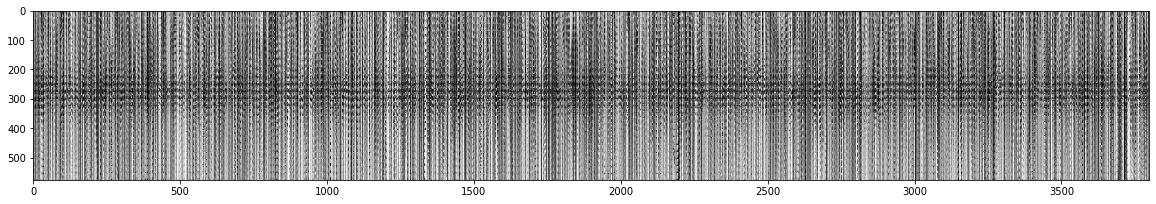

In [303]:
import matplotlib.pyplot as plt 
from sklearn import decomposition

dims = (24,24)
plt.figure(figsize=(20,10))
plt.imshow(x_train.T, cmap='gray')

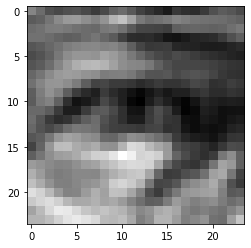

In [331]:
plt.imshow(np.reshape(x_trian[8,:], dims), cmap='gray')

In [370]:
u, s, v = decomposition.randomized_svd(x_train, 100)

In [371]:
u.shape, s.shape, v.shape

((3799, 100), (100,), (100, 576))

In [372]:
low_rank = u @ np.diag(s) @ v

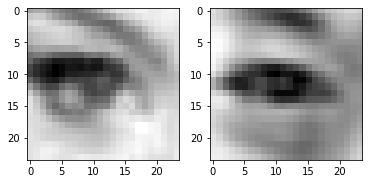

In [375]:
img = 100
plt.subplot(1,2,1)
plt.imshow(np.reshape(x_trian[img,:], dims), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.reshape(low_rank[img,:], dims), cmap='gray')

In [384]:
out = {'acc': 0, 'f1': 0, 'comp': 0}
for i in range(2, x_train.shape[0], 20):
  u, s, v = decomposition.randomized_svd(x_train, i)
  low_rank = u @ np.diag(s) @ v
  model = KMeans(init='k-means++', n_clusters = 2, n_init = 50, random_state=0)
  model.fit(low_rank)
  res = score(y_train, model.labels_)
  if out['acc'] < res['accuracy']:
    out['acc'] = res['accuracy']
    out['f1'] = res['f1 score']
    out['comp'] = i
  print(i)

2
22
42
62
82
102
122
142
162
182
202
222
242
262
282
302
322
342
362
382
402
422
442
462
482
502
522
542
562
582
602
622
642
662
682
702
722


KeyboardInterrupt: 

In [392]:
u, s, v = decomposition.randomized_svd(x_train, 22)
low_rank = u @ np.diag(s) @ v
model = KMeans(init='k-means++', n_clusters = 2, n_init = 50, random_state=0)
model.fit(low_rank)
score(y_train, model.labels_)

{'accuracy': 0.6380626480652803, 'f1 score': 0.650926631124651}

In [393]:
u, s, v = decomposition.randomized_svd(x_test, 22)
low_rank_test = u @ np.diag(s) @ v

In [394]:
score(y_test, model.predict(low_rank_test))

{'accuracy': 0.625, 'f1 score': 0.6445497630331753}

## Clustering in an `embedding space` 

The best i achieved by clustering in the original space was `{'accuracy': 0.625, 'f1 score': 0.6445497630331753}` on validation set. Let try now using fancier features than just row pixels

In [560]:
import torch
import torch.nn as nn 
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

In [580]:
model = models.resnet34(pretrained=True)
model.fc = nn.Identity()

In [581]:
class myData(Dataset):
    def __init__(self, pathToImgs, transforms=None):
        self.pathToImgs = pathToImgs
        self.imgNames = os.listdir(pathToImgs)
        self.transforms = transforms
    
    def __len__(self):
        return len(self.imgNames)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()
        
        img_name = os.path.join(self.pathToImgs, self.imgNames[idx])
        image = Image.open(img_name)
        label = self.imgNames[idx].split('.')[0]
        label = torch.tensor(int(label.split('_')[1]))
        
        if self.transforms:
            image = self.transforms(image)
            image = torch.cat(3*[image])
        else: 
            transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor() ])
            image = transform(image)
            image = torch.cat(3*[image])
            
        return image, label

In [ ]:
x_train = np.empty((len(os.listdir(path_tr)), 512))
y_train = np.empty((len(os.listdir(path_tr)), 1))

In [582]:
x_test = np.empty((len(os.listdir(path_ts)), 512))
y_test = np.empty((len(os.listdir(path_ts)), 1))

In [584]:
for i, batch in tqdm(enumerate(myData(path_ts))):
  img, label = batch
  x_test[i,:] = model(img.unsqueeze_(0)).detach().numpy()
  y_test[i] = label.item()
  



0it [00:00, ?it/s]

1it [00:00,  4.17it/s]

2it [00:00,  4.26it/s]

3it [00:00,  4.17it/s]

4it [00:01,  3.89it/s]

5it [00:01,  3.86it/s]

6it [00:01,  3.88it/s]

7it [00:01,  3.95it/s]

8it [00:01,  4.09it/s]

9it [00:02,  4.01it/s]

10it [00:02,  3.96it/s]

11it [00:02,  3.64it/s]

12it [00:03,  3.74it/s]

13it [00:03,  3.71it/s]

14it [00:03,  3.74it/s]

15it [00:03,  3.92it/s]

16it [00:04,  3.95it/s]

17it [00:04,  4.05it/s]

18it [00:04,  4.03it/s]

19it [00:04,  4.01it/s]

20it [00:05,  4.09it/s]

21it [00:05,  4.11it/s]

22it [00:05,  4.03it/s]

23it [00:05,  4.16it/s]

24it [00:06,  3.95it/s]

25it [00:06,  4.07it/s]

26it [00:06,  4.08it/s]

27it [00:06,  4.12it/s]

28it [00:07,  4.15it/s]

29it [00:07,  4.16it/s]

30it [00:07,  4.21it/s]

31it [00:07,  4.18it/s]

32it [00:07,  4.23it/s]

33it [00:08,  4.05it/s]

34it [00:08,  3.81it/s]

35it [00:08,  3.95it/s]

36it [00:09,  3.99it/s]

37it [00:09,  3.90it/s]

38it [00:09,  3.95it/s]

39it [00:09,  3.91it/s]

40it [00:10,

In [585]:
model = KMeans(init='k-means++', n_clusters = 2, n_init = 10, random_state=0)
model.fit(x_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [587]:
score(y_train, model.labels_)

{'accuracy': 0.756514872334825, 'f1 score': 0.7761916283571255}

In [588]:
score(y_test, model.predict(x_test))

{'accuracy': 0.765, 'f1 score': 0.7772511848341231}

Using pre-trained `Resnet-34` model to extract the features and make clustring on top of those features gave us a bit of improvement compare to the clustring in the original image space. **It must be pointed out, the new embeddimg space has almost the same dimentionaly as the original one**. In particular, we got these results `{'accuracy': 0.765, 'f1 score': 0.7772511848341231}`. Following this idea, the next logical step would be to train Auto-encoder and then use encoder to exptrcat embedding, then make clustering